In [1]:
# Segmentation
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
# Plot
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np 
import cv2

# Encoder - Decoder
# Texture
# sys.path.insert(0, '/home/giang.nguyen/FashionStyle/FashionPlus/generation')

# from options.train_options import TrainOptions
# from data.data_loader import CreateDataLoader
# from models.models import create_model
# import util.util as util
# import pickle


# # Shape
# sys.path.insert(1, '/home/giang.nguyen/FashionStyle/FashionPlus/separate_vae')


# Utils
import os
import time
from tqdm import tqdm 
import random
import pickle
import subprocess
###############################


```
# label index:  segment name
0            :  null
1            :  hat
2            :  hair
3            :  glasses
4            :  up(per clothing)
5            :  skirt
6            :  pants
7            :  dress
8            :  belt
9            :  r-shoe
10           :  l-shoe
11           :  face
12           :  r-leg
13           :  l-leg
14           :  r-arm
15           :  l-arm
16           :  bag
17           :  scarf
```

In [56]:
class Retrieval:
    classes = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear', \
               'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeved_dress', 'long_sleeved_dress', 'vest_dress', \
               'sling_dress', 'glasses', 'shoe', 'bag']
    mask_classes = ['up', 'up', 'up', 'up', 'up', 'up', 'pants', 'pants', 'skirt', 'dress', \
                    'dress', 'dress', 'dress', 'glasses', 'shoe', 'bag']
    seg_map = [4, 4, 4, 4, 4, 4, 6, 6, 5, 7, 7, 7, 7, 3, 9, 16]
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(classes))]
    threshold = {'short_sleeved_shirt': 0.5, 'long_sleeved_shirt': 0.5, 'short_sleeved_outwear': 0.5, 'long_sleeved_outwear': 0.4, \
               'vest': 0.5, 'sling': 0.5, 'shorts': 0.5, 'trousers': 0.5, 'skirt': 0.5, 'short_sleeved_dress': 0.5, 'long_sleeved_dress': 0.5, 'vest_dress': 0.5, \
               'sling_dress': 0.5, 'glasses': 0.2, 'shoe': 0.4, 'bag': 0.3}

    model_df2_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2.py'
    model_shoe_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb.py'
    model_df2_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/latest.pth'
    model_shoe_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/latest.pth'

    texture_file = 'generation/results/Lab/demo/database_test_features.p'
    shape_file = 'separate_vae/results/Lab/demo/database_test_shape_codes.p'

    create_database = True

    mask_dest = 'datasets/labels'

    def __init__(self):
        # Load mmdet models
        self.model_shoe = init_detector(self.model_shoe_config, self.model_shoe_pth, device='cuda:0')
        self.model_df2 = init_detector(self.model_df2_config, self.model_df2_pth, device='cuda:0')

        # Load encoder

        # Load database
        if not self.create_database:
            # self.database = load()
            pass
        else:
            with open(self.texture_file, 'rb') as f:
                self.texture_base = pickle.load(f)

            with open(self.shape_file, 'rb') as f:
                self.shape_base = pickle.load(f)

            self.database = dict()
            for key, val in tqdm(self.texture_base.items()):
                if key in self.shape_base:
                    self.database[key] = np.concatenate((self.texture_base[key], self.shape_base[key]), axis=1)

            self.bag_data = dict()
            for key,val in tqdm(self.database.items()):
                if key.split('_')[-1] == '16':
                    self.bag_data[key] = val
            print('Bag data created')


    def detect(self, image):
        file_name = image.split('/')[-1].replace('.jpg','.png')
        # print(file_name)
        tic = time.time()
        self.res_shoe = inference_detector(model=self.model_shoe, img=image)
        toc = time.time()
        self.res_df2  = inference_detector(model=self.model_df2, img=image)
        # print(self.res_shoe,'---', self.res_df2)   
        if len(np.array(self.res_shoe[0]).shape) > 1:
            tmp = np.random.rand(1,5)
            tmp[0,4] = 0.01
            self.res_shoe[0][0] = np.concatenate((self.res_shoe[0][0],tmp), axis = 0)
        if len(np.array(self.res_df2[0]).shape) > 1:
            tmp = np.random.rand(1,5)
            tmp[0,4] = 0.01
            self.res_df2[0][0] = np.concatenate((self.res_df2[0][0],tmp), axis = 0)

        self.res = np.concatenate((self.res_df2, self.res_shoe), axis=1)

    def draw_output(self, img, res, score=0.5):
        img = cv2.imread(img)
        res = self.res[0,:]
        # file_name = image.split('/')[-1]
        for i in range(len(res)):
            if len(res[i]) > 0 :
                for j in range(len(res[i])):
                    if res[i][j][4] > self.threshold[self.classes[i]]:
                        x1y1 = (res[i][j][0].astype(np.int32), res[i][j][1].astype(np.int32))
                        x4y4 = (res[i][j][2].astype(np.int32), res[i][j][3].astype(np.int32))

                        img = cv2.rectangle(img, x1y1, x4y4, self.colors[i], 2)
                        img = cv2.putText(img, '{} {:.4f}'.format(
                                        self.classes[i], res[i][j][4]),
                                        x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, self.colors[i], 2)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def create_input(self, image):
        file_name = image.split('/')[-1].replace('.jpg','.png')
        # self.masks = []
        self.mask = list()
        self.mask_items = dict()
        # self.mask_items = list()
        res = self.res[0,:]
        for i in range(len(res)):
            if len(res[i]) > 0 :
                for j in range(len(res[i])):
                    if res[i][j][4] > self.threshold[self.classes[i]]:
                        self.mask_items[self.mask_classes[i]] = 1*self.res[1,i][j]*self.seg_map[i]
                        # self.mask_items.append(1*self.res[1,i][j]*self.seg_map[i])
        self.mask = np.maximum.reduce([i for key, i in self.mask_items.items() if len(i) > 0])
        Image.fromarray(np.array(self.mask).astype(np.uint8)).save(f'{self.mask_dest}/{file_name}')
        # self.mask = np.maximum.reduce([i for i in self.mask_items if len(i) > 0])

    def encode(self):
        # process = subprocess.call(["./demo.sh"])
        subprocess.call(['sh','./demo.sh'])
        # process.wait() 
        print('Done sh')
        encode_text_file = 'generation/results/Lab/demo/test_features.p'
        encode_shape_file = 'separate_vae/results/Lab/demo/test_shape_codes.p'

        with open(encode_text_file, 'rb') as f:
            self.texture = pickle.load(f)

        with open(encode_shape_file, 'rb') as f:
            self.shape = pickle.load(f)

        self.bag_texture = self.texture['998_16']
        self.bag_shape = self.shape['998_16']

        self.bag = np.concatenate((self.bag_texture, self.bag_shape), axis=1)
        


    def load_database(self):
        pass

    def retrieval(self):
        dist = list()
        filename = list()

        for key, val in self.bag_data.items():
            # dist.append(np.sum(np.abs(bag- val)))
            dist.append(np.linalg.norm(self.bag - val, ord=1))
            filename.append(key)
        
        ranking = np.argsort(dist)[:3]


        fig, axs = plt.subplots(2, 2)
        img_name = filename[ranking[0]].replace('_16','')
        source = f'datasets/humanparsing/train_img/{img_name}.jpg'

        axs[0, 0].imshow(Image.open(source))
        axs[0, 0].set_title('Top 1')
        
        img_name = filename[ranking[1]].replace('_16','')
        source = f'datasets/humanparsing/train_img/{img_name}.jpg'
        axs[0, 1].imshow(Image.open(source))
        axs[0, 1].set_title('Top 2')

        img_name = filename[ranking[2]].replace('_16','')
        source = f'datasets/humanparsing/train_img/{img_name}.jpg'
        axs[1, 0].imshow(Image.open(source))
        axs[1, 0].set_title('Top 3')

        # img_name = filename[ranking[1]].replace('_16','')
        source = f'datasets/images/998.jpg'
        axs[1, 1].imshow(Image.open(source))
        axs[1, 1].set_title('Image')

        for ax in axs.flat:
            ax.label_outer()

        # for img in ranking:
        #     img_name = filename[img].replace('_16','')
        #     plt.figure()

        #     plt.imshow(Image.open(source))
        # plt.figure()
        # plt.imshow(Image.open('datasets/images/998.jpg'))
            

    def plot_image(self, image):
        pass

demo = Retrieval()
print('Initialized')
    

100%|██████████| 51543/51543 [00:00<00:00, 1421740.46it/s]Bag data created
Initialized



Done sh


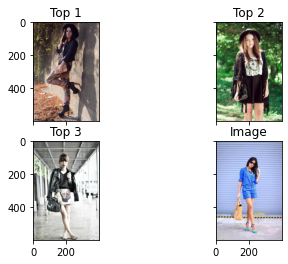

In [57]:
# detect, create input, encode, retrievals
image_dir = 'datasets/images/998.jpg'
demo.detect(image_dir)
demo.create_input(image_dir)
demo.encode()
demo.retrieval()

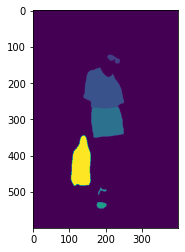

In [45]:
plt.imshow(demo.mask)

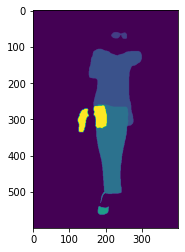

In [32]:
label = Image.open('datasets/labels/998.png')
plt.imshow(label)

In [43]:
print(np.unique(np.array(label)))
print(np.unique(np.array(demo.mask)))

[ 0  2  4  5  6  9 10 11 12 13 14 15 16]
[ 0  4  5  9 16]


In [ ]:
image = 'datasets/humanparsing/train_img/dataset10k_7017.jpg'
# image = 'datasets/humanparsing/train_img/2500_509.jpg'

model_df2_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2.py'
model_shoe_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb.py'
model_df2_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/latest.pth'
model_shoe_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/latest.pth'


model_shoe = init_detector(model_shoe_config, model_shoe_pth, device='cuda:0')
model_df2 = init_detector(model_df2_config, model_df2_pth, device='cuda:0')

res_shoe = inference_detector(model=model_shoe, img=image)
res_df2  = inference_detector(model=model_df2, img=image)  

# np_res_shoe = np.array([np.array([np.expand_dims(np.array(j),axis=0) for j in i if len()]) for i in res_shoe])
# print(np_res_shoe.shape)
# print(np_res_shoe.shape)
# print(np.array(res_shoe))
# res = np.concatenate((res_df2, res_shoe), axis=1)

show_result_pyplot(model_shoe, image, res_shoe)
# res_shoe = [[j[0] for j in i] for i in res_shoe]

# show_result_pyplot(model_df2, image, res_df2)
# plt.imshow(Image.open(test_image))
# print(len(res_shoe[1]))
for i in res_shoe:
    tmp = np.array(i)
    print(tmp.shape, len(tmp.shape))
    print('****')
    for j in i:
        print('-----')
        tmp = np.array(j)
        # tmp = np.expand_dims(tmp, axis=0)
        print(tmp.shape)
        # j = tmp
        for k in j:
            print('llll')
            tmp = np.array(k)
            # tmp = np.expand_dims(tmp, axis=0)

            print(tmp.shape)
            # k = tmp

tmp1 = res_shoe
# tmp = np.array(np.array[i] for i in np.array(res_shoe))
# print(t)
# demo.detect(test_image)
# img = demo.draw_output(test_image, demo.res[0,:])

In [ ]:
print(res_shoe[0][0] )
tmp = np.random.rand(1,5)
tmp[0,4] = 0.01
print(tmp)
res_shoe[0][0] = np.concatenate((res_shoe[0][0],tmp), axis = 0)

In [ ]:
np.array(res_shoe)

In [ ]:
tmp = np.array(shoe_bbox)
bboxes = np.vstack(shoe_bbox)
labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)
    for i, bbox in enumerate(shoe_bbox)
]
print(bboxes.shape)
print(labels)

In [ ]:
for i in tmp1:
    # print(len(i))
    print(np.squeeze(np.array(i)).shape)
    for j in i:
        print(np.array(j).shape)
        print(len(j))
    print('----')

In [ ]:
print(np.array(tmp1[0]), np.array(tmp1[0]).shape)
print('----')
print(tmp1[0])
print('----')
print(tmp2[0])

In [ ]:
tmp3 = np.array([np.array(i) for i in tmp2])
# print(np.array(tmp2[0]), np.array(tmp2[0]).shape)
print(tmp3[0], tmp3[0].shape, type(tmp3))
print(type(tmp3[0]), tmp3[0].shape)
print(type(np.array(tmp1[0])),np.array(tmp1[0]).shape)#, tmp1[0].shape)
print(tmp2[0], type(tmp2[0]))
print(tmp1[0], type(tmp1[0]))


In [ ]:
tmp1 = [np.expand_dims([np.expand_dims([np.expand_dims(np.array(k), axis=0) for k in i]),axis=0) for i in j]),axis=0) for j in tmp1]

In [ ]:
np.array(tmp1)

In [ ]:
a = [np.zeros((224,224,3)), np.zeros((224,224,3)), np.zeros((224,2,2))]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
image = 'datasets/humanparsing/train_img/Multi_340.jpg'
plt.imshow(Image.open(image))

# DATABASE Test

In [1]:
import pickle
from tqdm import tqdm 

texture_file = 'generation/results/Lab/demo/database_features.p'
shape_file = 'separate_vae/results/Lab/demo/database_shape_codes.p'

with open(texture_file, 'rb') as f:
    texture_base = pickle.load(f)

with open(shape_file, 'rb') as f:
    shape_base = pickle.load(f)

# print(texture_base.keys())
# print(shape_base.keys())

In [2]:
encode_text_file = 'generation/results/Lab/demo/test_features.p'
encode_shape_file = 'separate_vae/results/Lab/demo/test_shape_codes.p'

with open(encode_text_file, 'rb') as f:
    texture = pickle.load(f)

with open(encode_shape_file, 'rb') as f:
    shape = pickle.load(f)

print(texture.keys())
print(shape.keys())


dict_keys(['998_0', '998_2', '998_4', '998_5', '998_6', '998_9', '998_10', '998_11', '998_12', '998_13', '998_14', '998_15', '998_16'])
dict_keys(['998_16', '998_10', '998_5', '998_7', '998_0'])


In [3]:
texture_bag = texture['998_16']
shape_bag = shape['998_16']
print(texture_bag.shape, shape_bag.shape)

(1, 8) (1, 8)


In [4]:
import numpy as np 
item = np.concatenate((texture_bag,shape_bag), axis = 1)

In [5]:
print(item, item.shape)

[[-7.46698901e-02  4.39980298e-01  6.05078161e-01  5.07194586e-02
  -2.41041407e-01 -4.78394210e-01 -6.43021986e-02 -2.16086403e-01
   7.28091180e-01  1.36934531e+00  1.08951107e-02 -6.80196226e-01
   2.01175995e-02  1.20124221e-03 -1.25028007e-03 -1.18443929e-02]] (1, 16)


In [6]:
database = dict()
for key, val in tqdm(texture_base.items()):
    if key in shape_base:
        database[key] = np.concatenate((texture_base[key], shape_base[key]), axis=1)

print(len(database))

100%|██████████| 193301/193301 [00:00<00:00, 566805.53it/s]51543



# Retrieval
for loop over database

calculate cosine distance

find top 4 argmin

retriev corresponding file name


In [7]:
bag_data = dict()
for key,val in tqdm(database.items()):
    if key.split('_')[-1] == '16':
        bag_data[key] = val

100%|██████████| 51543/51543 [00:00<00:00, 1027202.11it/s]


In [8]:
bag = item
print(bag)
print(bag_data['dataset10k_3144_16'])
print(texture['998_16'])
print(shape['998_16'])

distance = (np.abs(bag - bag_data['dataset10k_3144_16']))
print(np.sum(distance))
print(distance)

[[-7.46698901e-02  4.39980298e-01  6.05078161e-01  5.07194586e-02
  -2.41041407e-01 -4.78394210e-01 -6.43021986e-02 -2.16086403e-01
   7.28091180e-01  1.36934531e+00  1.08951107e-02 -6.80196226e-01
   2.01175995e-02  1.20124221e-03 -1.25028007e-03 -1.18443929e-02]]
[[-0.15671656  0.19619663  0.44866377 -0.56620347 -0.26017478  0.15901288
   0.076644   -0.1836936  -0.59932262 -0.71358049  0.42667228  2.01868176
   1.64040041  0.2759352  -1.49888301  1.60563028]]
[[-0.07466989  0.4399803   0.60507816  0.05071946 -0.24104141 -0.47839421
  -0.0643022  -0.2160864 ]]
[[ 7.2809118e-01  1.3693453e+00  1.0895111e-02 -6.8019623e-01
   2.0117600e-02  1.2012422e-03 -1.2502801e-03 -1.1844393e-02]]
13.464166043326259
[[0.08204667 0.24378367 0.15641439 0.61692293 0.01913337 0.63740709
  0.14094619 0.0323928  1.3274138  2.0829258  0.41577717 2.69887799
  1.62028281 0.27473396 1.49763273 1.61747467]]


In [9]:
print(bag_data['dataset10k_2966_16'])

[[-0.33799264  0.10142203 -0.06256121 -0.49691704  0.36221164 -0.5507977
   0.49197909 -0.28246769 -0.53180766 -1.33070791  1.15643346  0.83405143
   1.11235213  0.98322511 -2.1329453   0.8680535 ]]


In [15]:
dist = list()
filename = list()

for key, val in bag_data.items():
    # dist.append(np.sum(np.abs(bag- val)))
    dist.append(np.linalg.norm(bag - val, ord=2))
    filename.append(key)    

In [16]:
print(len(dist), len(filename))
print(np.linalg.norm(bag - bag_data['dataset10k_3144_16'], ord=2))
# print(dist)


9301 9301
4.692135342636352


In [17]:
# tmp = np.argpartition(dist, 3)
tmp = np.argmin(dist)
tmp = np.argsort(dist)[:3]
# print(tmp[:3])
# print(dist[tmp[:3]])
print(tmp)
# print(dist[tmp])

[7892 5769 8537]


In [18]:
filename[tmp[1]]

'dataset10k_4747_16'

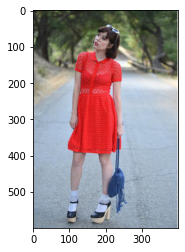

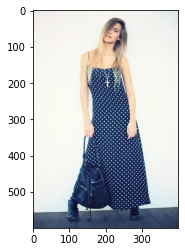

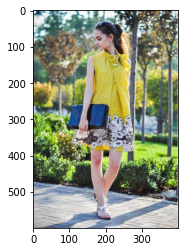

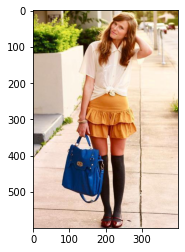

In [21]:
# source = 'datasets/humanparsing/train_img/dataset10k_7234.jpg'
import matplotlib.pyplot as plt 
from PIL import Image 

for img in tmp:
    img_name = filename[img].replace('_16','')
    plt.figure()

    source = f'datasets/humanparsing/train_img/{img_name}.jpg'
    plt.imshow(Image.open(source))
plt.figure()
plt.imshow(Image.open('datasets/images/998.jpg'))